In [1]:
%matplotlib inline

import numpy as np
import os
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
from PIL import Image
import math
import importlib
import helper


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


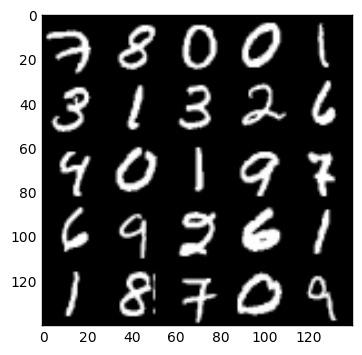

In [3]:
num_img = 25
img = mnist.train.images[:num_img]
img = img.reshape(num_img,28,28,1)

plt.imshow(helper.images_square_grid(img, 'L'), cmap='gray')
#plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [21]:
# Train the network
def train(epoch_count, batch_size, embedded_image_dim, learning_rate, beta1, img_shape, data_image_mode, logs_path):
    
    print_every = 2
    show_every = 40
    
    samples, losses = [], []
    steps = 0
    
    # get tf input variables
    input_images_tf, target_output_images_tf, embedded_image_input_tf, learning_rate_tf = sens.model_inputs(img_shape, img_shape, len(data_image_mode), embedded_image_dim)

    # get loss and output variables
    autoencoder_cost_tf, autoencoder_output_tf, discriminator_cost_tf, discriminator_output_tf, generated_output_tf, discriminator_loss_fake, discriminator_loss_real, generator_cost_tf =  sens.model_loss(input_images_tf, len(data_image_mode), target_output_images_tf, embedded_image_dim, embedded_image_input_tf)
    tf.summary.scalar('autoencoder_cost', autoencoder_cost_tf)
    tf.summary.scalar('generator_cost', generator_cost_tf)
    tf.summary.scalar('discriminator_cost',discriminator_cost_tf)
    tf.summary.scalar('discriminator_real_cost',discriminator_loss_real)
    tf.summary.scalar('discriminator_fake_cost',discriminator_loss_fake)
    
    # create model optimizers
    autoencoder_optimizer_tf, discriminator_optimizer_tf, generator_optimizer_tf = sens.model_opt(autoencoder_cost_tf, discriminator_cost_tf, generator_cost_tf, learning_rate_tf, beta1)
    
    
    merged_tf = tf.summary.merge_all()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        file_writer = tf.summary.FileWriter(logs_path,sess.graph)
        
        for epoch_i in range(epoch_count):

            for ii in range(mnist.train.num_examples//batch_size):
                
                
                steps += 1
#
                # Run optimizers
                
                batch_images,target_images = helper.get_noisy_target_images(mnist.train.next_batch(batch_size),img_shape,0.4,len(data_image_mode),augment=True)

                _, autoencoder_training_cost, summary = sess.run([autoencoder_optimizer_tf,\
                                                                  autoencoder_cost_tf,\
                                                                  merged_tf],\
                                                        feed_dict={input_images_tf: batch_images, \
                                                       target_output_images_tf: target_images, \
                                                       embedded_image_input_tf: np.clip(np.random.uniform(size=(batch_size,embedded_image_dim)),0.,1.),\
                                                       learning_rate_tf:learning_rate})
                
                if epoch_i >= 1:
                    batch_images,target_images = helper.get_noisy_target_images(mnist.train.next_batch(batch_size),img_shape,0.4,len(data_image_mode))


                    _, autoencoder_training_cost, summary, _ = sess.run([autoencoder_optimizer_tf,\
                                                                      autoencoder_cost_tf,\
                                                                      merged_tf, \
                                                                      generator_optimizer_tf],\
                                                            feed_dict={input_images_tf: batch_images, \
                                                           target_output_images_tf: target_images, \
                                                           embedded_image_input_tf: np.clip(np.random.uniform(size=(batch_size,embedded_image_dim)),0.,1.),\
                                                           learning_rate_tf:learning_rate})

                    batch_images,target_images = helper.get_noisy_target_images(mnist.train.next_batch(batch_size),img_shape,0.4,len(data_image_mode))

                    _, autoencoder_training_cost, summary, _ = sess.run([autoencoder_optimizer_tf,\
                                                                      autoencoder_cost_tf,\
                                                                      merged_tf, \
                                                                      discriminator_optimizer_tf],\
                                                            feed_dict={input_images_tf: batch_images, \
                                                           target_output_images_tf: target_images, \
                                                           embedded_image_input_tf: np.clip(np.random.normal(size=(batch_size,embedded_image_dim)),0.,1.),\
                                                           learning_rate_tf:learning_rate})
                
                if steps % print_every == 0:
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "AE Cost: {:.4f}".format(autoencoder_training_cost))
                    
                    file_writer.add_summary(summary,steps)
                    # Save losses to view after training
                    losses.append((autoencoder_training_cost))

                if steps % show_every == 0:
                    helper.show_autoencoder_output(sess, img_shape, mnist.train.next_batch(25),input_images_tf, autoencoder_output_tf, generated_output_tf, embedded_image_input_tf, embedded_image_dim,  data_image_mode,label='pics/'+logs_path[10:])
        
        helper.show_autoencoder_output(sess, img_shape, mnist.train.next_batch(25),input_images_tf, autoencoder_output_tf, generated_output_tf, embedded_image_input_tf, embedded_image_dim, data_image_mode,label='pics/'+logs_path[10:])
                

max_in =  1.0   max_out =  0.902326
min_in =  0.0   min_out =  3.28287e-10


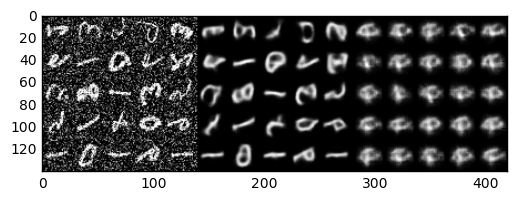

pics/bs_16_ed_32_lr_0.001
Epoch 1/6... AE Cost: 0.1963
Epoch 1/6... AE Cost: 0.1772
Epoch 1/6... AE Cost: 0.1712
Epoch 1/6... AE Cost: 0.1831
Epoch 1/6... AE Cost: 0.1757
Epoch 1/6... AE Cost: 0.1723
Epoch 1/6... AE Cost: 0.1879


In [ ]:
import sens_network as sens
import helper
importlib.reload(sens)
importlib.reload(helper)

batch_size = 16
embedded_dim = 32
learning_rate = 0.001
beta1 = 0.4
data_shape = 28
rates = [0.001]
epochs = 6

# mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

# for batch_size in [8,16,32]:
#     for embedded_dim in [32,64,128]:
#         for learning_rate_i in range(2):
#             learning_rate = rates[learning_rate_i]
parameter_label = './logs/11/'+'bs_'+str(batch_size)+'_ed_'+str(embedded_dim)+'_lr_'+str(learning_rate)
with tf.Graph().as_default():
    train(epochs, batch_size, embedded_dim, learning_rate, beta1, data_shape, 'L', parameter_label)
    
